In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import math
import numpy as np
import pandas as pd
!pip install scikit-plot
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils
import time

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    
    net.add(Dropout(0.5, name='dropout_3'))
    
    
    
    
    # net.add(
    #     Conv2D(
    #         filters=512,
    #         kernel_size=(3,3),
    #         activation='elu',
    #         padding='same',
    #         kernel_initializer='he_normal',
    #         name='conv2d_7'
    #     )
    # )
    # net.add(BatchNormalization(name='batchnorm_7'))
    
    # net.add(
    #     Conv2D(
    #         filters=512,
    #         kernel_size=(3,3),
    #         activation='elu',
    #         padding='same',
    #         kernel_initializer='he_normal',
    #         name='conv2d_8'
    #     )
    # )
    # net.add(BatchNormalization(name='batchnorm_8'))
    
    # net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_4'))
    
    # net.add(Dropout(0.5, name='dropout_4'))

    
    
    
    
    
#     net.add(
#         Conv2D(
#             filters=1024,
#             kernel_size=(2,2),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_9'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_10'))
    
#     net.add(
#         Conv2D(
#             filters=1024,
#             kernel_size=(2,2),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_10'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_11'))
    
# #     net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_5'))
    
#     net.add(Dropout(0.5, name='dropout_6'))
    
    
    
    
    
    
    
    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_9'))
    
    net.add(Dropout(0.6, name='dropout_5'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 64 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


504/504 [==============================] - 22s 41ms/step - loss: 2.4771 - accuracy: 0.2010 - val_loss: 1.6843 - val_accuracy: 0.3578
Epoch 2/100
504/504 [==============================] - 21s 41ms/step - loss: 1.7606 - accuracy: 0.2950 - val_loss: 1.5758 - val_accuracy: 0.3672
Epoch 3/100
504/504 [==============================] - 21s 41ms/step - loss: 1.5997 - accuracy: 0.3738 - val_loss: 1.4986 - val_accuracy: 0.4511
Epoch 4/100
504/504 [==============================] - 21s 41ms/step - loss: 1.4729 - accuracy: 0.4279 - val_loss: 1.2748 - val_accuracy: 0.5057
Epoch 5/100
504/504 [==============================] - 21s 41ms/step - loss: 1.4004 - accuracy: 0.4648 - val_loss: 1.2760 - val_accuracy: 0.5205
Epoch 6/100
504/504 [==============================] - 21s 41ms/step - loss: 1.3317 - accuracy: 0.4950 - val_loss: 1.1876 - val_accuracy: 0.5528
Epoch 7/100
504/504 [==============================] - 21s 42ms/step - loss: 1.2785 - accuracy: 0.5145 - val_loss: 1.1608 - val_accuracy: 0.56

In [ ]:
model_yaml = model.to_yaml()
with open("/content/drive/MyDrive/Kaggle/fer2013/model_{}.yaml".format(time.time()), "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("/content/drive/MyDrive/Kaggle/fer2013/model_{}.h5".format(time.time()))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

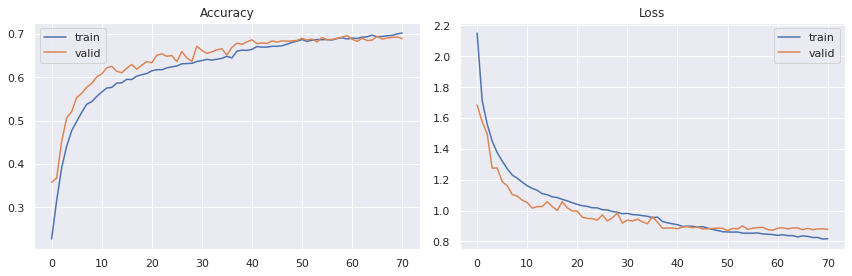

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

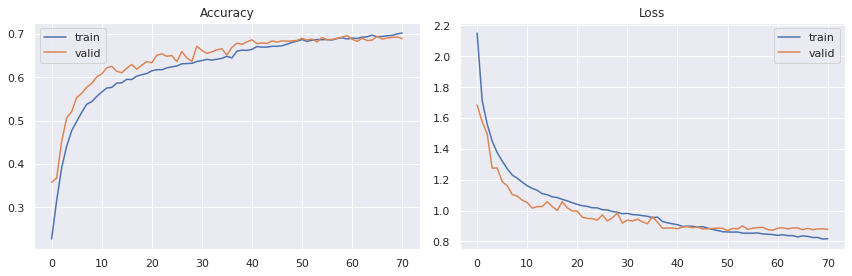

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


total wrong validation predictions: 1092


              precision    recall  f1-score   support

           0       0.63      0.65      0.64       495
           1       0.88      0.53      0.66        55
           2       0.57      0.45      0.50       512
           3       0.88      0.88      0.88       899
           4       0.61      0.59      0.60       608
           5       0.76      0.77      0.76       400
           6       0.61      0.75      0.67       620

    accuracy                           0.70      3589
   macro avg       0.71      0.66      0.67      3589
weighted avg       0.70      0.70      0.69      3589



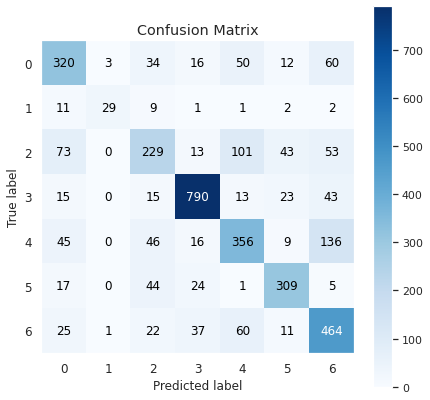

In [ ]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [ ]:
mapper = emotion_label_to_text
# emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


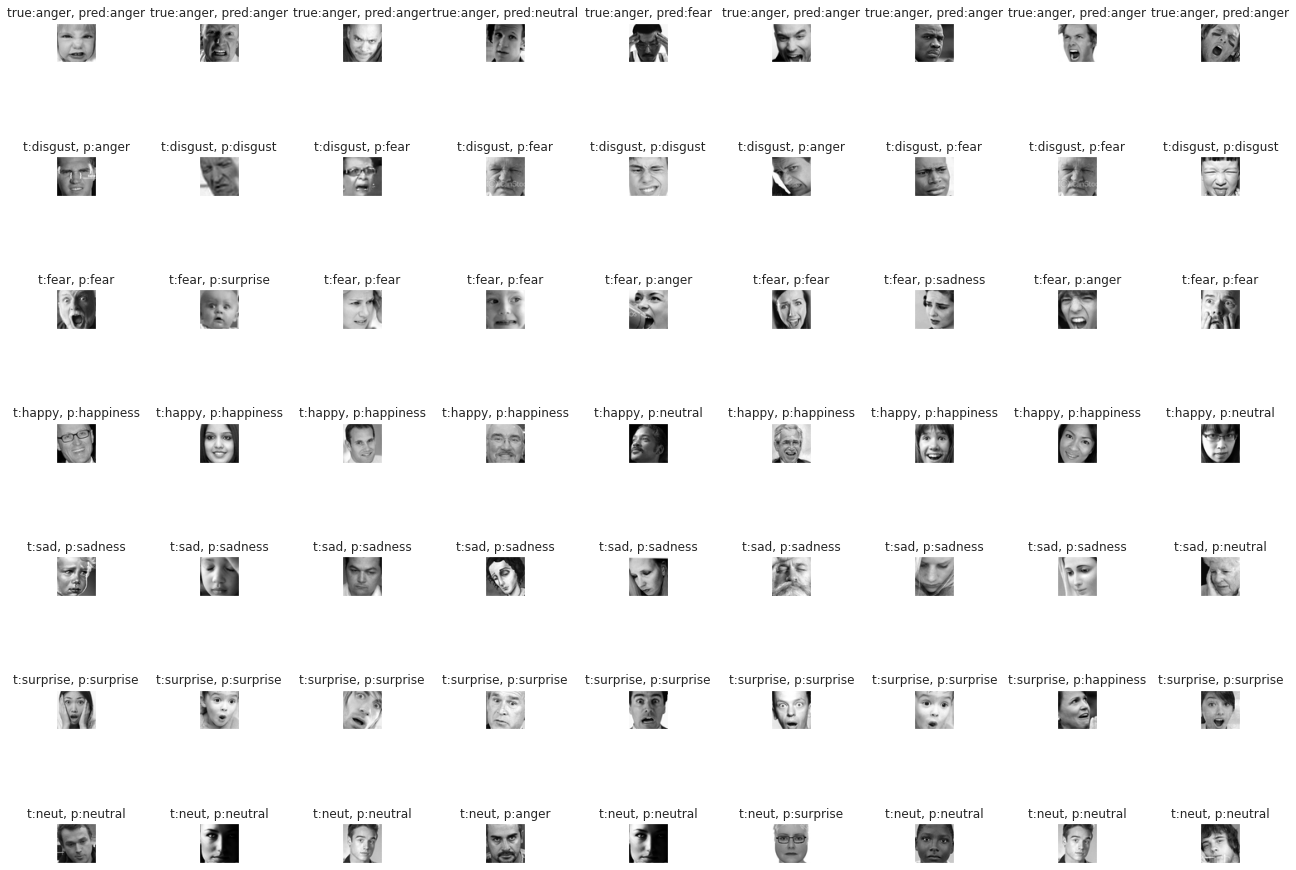

In [ ]:
np.random.seed(2)
random_anger_imgs = np.random.choice(np.where(y_valid[:,0] == 1)[0], size=9)
random_disgust_imgs = np.random.choice(np.where(y_valid[:,1] == 1)[0], size=9)
random_fear_imgs = np.random.choice(np.where(y_valid[:,2] == 1)[0], size=9)
random_happiness_imgs = np.random.choice(np.where(y_valid[:,3] == 1)[0], size=9)
random_sadness_imgs = np.random.choice(np.where(y_valid[:,4] == 1)[0], size=9)
random_surprise_imgs = np.random.choice(np.where(y_valid[:,5] == 1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:,6] == 1)[0], size=9)

imgs = enumerate(zip(random_anger_imgs, random_disgust_imgs, random_fear_imgs, random_happiness_imgs, random_sadness_imgs, random_surprise_imgs, random_neutral_imgs))

fig = pyplot.figure(1, (18, 14))

for i, (ang, dis, fea, hap, sad, sur, neu) in imgs:
        ax = pyplot.subplot(7, 9, i+1)
        sample_img = X_valid[ang,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:anger, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(7, 9, i+10)
        sample_img = X_valid[dis,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:disgust, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")
        
        ax = pyplot.subplot(7, 9, i+19)
        sample_img = X_valid[fea,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")
        
        ax = pyplot.subplot(7, 9, i+28)
        sample_img = X_valid[hap,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:happy, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")
        
        ax = pyplot.subplot(7, 9, i+37)
        sample_img = X_valid[sad,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:sad, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")
        
        ax = pyplot.subplot(7, 9, i+46)
        sample_img = X_valid[sur,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:surprise, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")
        
        ax = pyplot.subplot(7, 9, i+55)
        sample_img = X_valid[neu,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


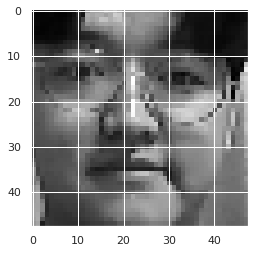

In [ ]:
import cv2
import dlib
detector = dlib.get_frontal_face_detector()
def rect2bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)
def getLargestFaceBoundingBox(rgbImg):
        assert rgbImg is not None

        faces = detector(rgbImg, 1)
        if (len(faces) > 0) or len(faces) == 1:
            return max(faces, key=lambda rect: rect.width() * rect.height())
        else:
            return None
def img2csv(img):
    img = cv2.resize(img,(48,48))
    return img

from google.colab.patches import cv2_imshow

def img2data(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # cv2_imshow(img)
    box = getLargestFaceBoundingBox(img)
    if box == None:
        return None
    x, y, w, h = rect2bb(box)
    # print(x, y, w, h)
    face = img[y: y+h, x: x+w]
    gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    # cv2_imshow(gray)
    data = img2csv(gray)
    return data

test_vid_dir = ""

vs = cv2.VideoCapture(test_vid_dir)

count = 0
while True:
    ret, img = vs.read()
    count += 1
    if ret and count % 10 == 0:
        data = img2data(img)
        image = np.reshape(data,(48,48))

        data = np.reshape(data, (1,48,48,1))
        ax= pyplot.subplot(1,1,1)
        ax.imshow(image, cmap='gray')
        pred = model.predict_classes(data)
        # pred = np.argmax(pred, axis = 1)
        print(pred)    
    elif ret:
        pass
    else:
        break


# Image Test

In [ ]:
import numpy as np
from PIL import Image
import csv
from os import listdir
from os.path import isfile, join
from matplotlib.pyplot import imshow

In [ ]:
anger = "/content/drive/MyDrive/Kaggle/fer2013/random-images-for-face-emotion-recognition/anger"
contempt = "/content/drive/MyDrive/Kaggle/fer2013/random-images-for-face-emotion-recognition/contempt"
disgust = "/content/drive/MyDrive/Kaggle/fer2013/random-images-for-face-emotion-recognition/disgust"
fear = "/content/drive/MyDrive/Kaggle/fer2013/random-images-for-face-emotion-recognition/fear"
happiness = "/content/drive/MyDrive/Kaggle/fer2013/random-images-for-face-emotion-recognition/happiness"
neutrality = "/content/drive/MyDrive/Kaggle/fer2013/random-images-for-face-emotion-recognition/neutrality"
sadness = "/content/drive/MyDrive/Kaggle/fer2013/random-images-for-face-emotion-recognition/sadness"
surprise = "/content/drive/MyDrive/Kaggle/fer2013/random-images-for-face-emotion-recognition/surprise"



anger = [join(anger, f) for f in listdir(anger) if isfile(join(anger, f))]
contempt = [join(contempt, f) for f in listdir(contempt) if isfile(join(contempt, f))]
disgust = [join(disgust, f) for f in listdir(disgust) if isfile(join(disgust, f))]
fear = [join(fear, f) for f in listdir(fear) if isfile(join(fear, f))]
happiness = [join(happiness, f) for f in listdir(happiness) if isfile(join(happiness, f))]
neutrality = [join(neutrality, f) for f in listdir(neutrality) if isfile(join(neutrality, f))]
sadness = [join(sadness, f) for f in listdir(sadness) if isfile(join(sadness, f))]
surprise = [join(surprise, f) for f in listdir(surprise) if isfile(join(surprise, f))]



In [ ]:
def img2csv(img_list):
    imgs = list()
    for img in img_list:
        img = Image.open(img)
        img = img.resize((48,48))
        img = np.array(img)
        imgs.append(img.flatten())
    imgs = np.asarray(imgs)
    # imgs = np.reshape(imgs,(48,48))
    return imgs

anger = img2csv(anger)
contempt = img2csv(contempt)
disgust = img2csv(disgust)
fear = img2csv(fear)
happiness = img2csv(happiness)
neutrality = img2csv(neutrality)
sadness = img2csv(sadness)
surprise = img2csv(surprise)


In [ ]:
print(anger.shape)
print(contempt.shape)
print(disgust.shape)
print(fear.shape)
print(happiness.shape)
print(neutrality.shape)
print(sadness.shape)
print(surprise.shape)



(887, 2304)
(208, 2304)
(439, 2304)
(570, 2304)
(1406, 2304)
(524, 2304)
(746, 2304)
(775, 2304)


In [ ]:
anger = np.reshape(anger, (887, 48, 48, 1))
contempt = np.reshape(contempt, (208, 48, 48, 1))
disgust = np.reshape(disgust, (439, 48, 48, 1))
fear = np.reshape(fear, (570, 48, 48, 1))
happiness = np.reshape(happiness, (1406, 48, 48, 1))
neutrality = np.reshape(neutrality, (524, 48, 48, 1))
sadness = np.reshape(sadness, (746, 48, 48, 1))
surprise = np.reshape(surprise, (775, 48, 48, 1))


In [ ]:
anger_pred = model.predict_classes(anger)
cont_pred = model.predict_classes(contempt)
dis_pred = model.predict_classes(disgust)
fear_pred = model.predict_classes(fear)
hap_pred = model.predict_classes(happiness)
neu_pred = model.predict_classes(neutrality)
sad_pred = model.predict_classes(sadness)
sur_pred = model.predict_classes(surprise)

anger_y = [0 for _ in range(len(anger_pred))]
cont_y = [7 for _ in range(len(cont_pred))]
dis_y = [1 for _ in range(len(dis_pred))]
fear_y = [2 for _ in range(len(fear_pred))]
hap_y = [3 for _ in range(len(hap_pred))]
sad_y = [4 for _ in range(len(sad_pred))]
sur_y = [5 for _ in range(len(sur_pred))]
neu_y = [6 for _ in range(len(neu_pred))]

print (sklearn.metrics.accuracy_score(anger_y, anger_pred))
print(sklearn.metrics.accuracy_score(cont_y, cont_pred))
print(sklearn.metrics.accuracy_score(dis_y, dis_pred))
print(sklearn.metrics.accuracy_score(fear_y, fear_pred))
print(sklearn.metrics.accuracy_score(hap_y, hap_pred))
print(sklearn.metrics.accuracy_score(sad_y, sad_pred))
print(sklearn.metrics.accuracy_score(sur_y, sur_pred))
print(sklearn.metrics.accuracy_score(neu_y, neu_pred))


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9954904171364148
0.0
0.0
0.0
0.0
0.002680965147453083
0.003870967741935484
0.0057251908396946565


In [ ]:
print(mapper)

{0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}


In [ ]:
count = 0
for a in anger_pred:
    pred= mapper[a]
    if pred == "anger":
        count += 1
    print(mapper[a])

print(count / len(anger_pred))

anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
ange

In [ ]:
count = 0
for a in cont_pred:
    print(mapper[a])

anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
surprise
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
a

In [ ]:
count = 0
for a in dis_pred:
    pred= mapper[a]
    if pred == "disgust":
        count += 1
    print(mapper[a])

print(count / len(dis_pred))

anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
ange

In [ ]:
count = 0
for a in fear_pred:
    pred= mapper[a]
    if pred == "fear":
        count += 1
    print(mapper[a])

print(count / len(fear_pred))

anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
neutral
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
an

In [ ]:
count = 0
for a in hap_pred:
    pred= mapper[a]
    if pred == "happiness":
        count += 1
    print(mapper[a])

print(count / len(hap_pred))

anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
ange

In [ ]:
count = 0
for a in sad_pred:
    pred= mapper[a]
    if pred == "sadness":
        count += 1
    print(mapper[a])

print(count / len(sad_pred))

anger
anger
anger
anger
neutral
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
neutral
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger


In [ ]:
count = 0
for a in sur_pred:
    pred= mapper[a]
    if pred == "surpirse":
        count += 1
    print(mapper[a])

print(count / len(sur_pred))

neutral
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
an

In [ ]:
count = 0
for a in neu_pred:
    pred= mapper[a]
    if pred == "neutral":
        count += 1
    print(mapper[a])

print(count / len(neu_pred))

anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
neutral
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
sadness
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger
anger


In [ ]:
pred = model.predict_classes(X_valid)
import sklearn

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
y_true = np.argmax(y_valid, axis=1)
sklearn.metrics.accuracy_score(y_true, pred)

0.6957369740874896